In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

In [3]:
data = yf.download(
    tickers = "ADANIPOWER.NS",
    start = "2021-06-10",
    end = "2021-06-11",
    interval = '1m',
    auto_adjust = True,
    threads = True
)

[*********************100%***********************]  1 of 1 completed


In [5]:
print(data)

                                 Open        High         Low       Close  \
Datetime                                                                    
2021-06-10 09:15:00+05:30  156.850006  163.850006  156.850006  162.100006   
2021-06-10 09:16:00+05:30  162.300003  162.350006  158.250000  160.500000   
2021-06-10 09:17:00+05:30  160.399994  162.699997  160.399994  162.149994   
2021-06-10 09:18:00+05:30  162.250000  163.000000  161.750000  162.300003   
2021-06-10 09:19:00+05:30  162.350006  162.399994  160.699997  161.600006   
...                               ...         ...         ...         ...   
2021-06-10 15:25:00+05:30  154.350006  154.350006  154.050003  154.149994   
2021-06-10 15:26:00+05:30  154.199997  154.350006  154.100006  154.350006   
2021-06-10 15:27:00+05:30  154.350006  154.500000  154.149994  154.149994   
2021-06-10 15:28:00+05:30  154.399994  154.500000  154.199997  154.300003   
2021-06-10 15:29:00+05:30  154.399994  154.750000  154.199997  154.500000   

In [8]:
data['Typical Price'] = (data['High'] + data['Close'] + data['Low'])/3
print(data['Typical Price'])

Datetime
2021-06-10 09:15:00+05:30    160.933339
2021-06-10 09:16:00+05:30    160.366669
2021-06-10 09:17:00+05:30    161.749995
2021-06-10 09:18:00+05:30    162.350001
2021-06-10 09:19:00+05:30    161.566666
                                ...    
2021-06-10 15:25:00+05:30    154.183334
2021-06-10 15:26:00+05:30    154.266673
2021-06-10 15:27:00+05:30    154.266663
2021-06-10 15:28:00+05:30    154.333333
2021-06-10 15:29:00+05:30    154.483332
Name: Typical Price, Length: 375, dtype: float64


In [9]:
price_array = np.array(data['Typical Price'])

In [14]:
training_period = 20
feature_price_list = []
label_price_list = []
for i in range(training_period, len(price_array)):
    feature_price_list.append(price_array[i - training_period: i])
    label_price_list.append(price_array[i])

In [15]:
def lin_reg(training_array):
    n = len(training_array)
    sum_x2 = n*(n+1)*(2*n+1)/6
    sum_x = n*(n+1)/2
    sum_x_squared = sum_x**2
    sum_y = np.sum(training_array)
    sum_xy = 0
    for i in range(n):
        sum_xy += training_array[i]*(i+1)
    
    b = ((n*sum_xy) - (sum_x*sum_y))/((n*sum_x2) - sum_x_squared)
    a = (sum_y - b*sum_x)/n
    
    pred = b*(n+1) + a
    return pred
    

In [18]:
df_weights = pd.DataFrame(index = [("Test" + str(i+1)) for i in range(len(label_price_list))], columns = [str(i) for i in range(2,training_period+1)])
ctr = 1
for feat,lbl in zip(feature_price_list, label_price_list):
    r2_list = []
    for i in range(2, training_period+1):
        r = lbl - lin_reg(feat[-i:])
        r2 = r**2
        r2_list.append(r2)
    max_r2 = max(r2_list)
    weights_list = []
    for i in r2_list:
        weights_list.append(max_r2 - i)
    sum_weights = sum(weights_list)
    for i in range(len(weights_list)):
        weights_list[i] = weights_list[i]*100/sum_weights
        df_weights.loc["Test" + str(ctr), str(i+2)] = weights_list[i]
    ctr += 1
final_weights_list = [(i,df_weights.mean(axis=0)[str(i)]) for i in range(2, training_period+1)]
print(final_weights_list)

[(2, 7.146135638480449), (3, 6.862645766588433), (4, 6.452295766687756), (5, 6.16845396198824), (6, 5.96108446012612), (7, 5.774382611267274), (8, 5.594487437759608), (9, 5.432317631672358), (10, 5.287417113607386), (11, 5.141885548820611), (12, 4.978350947573623), (13, 4.852127430568998), (14, 4.750562716708041), (15, 4.618899957317268), (16, 4.480496545660656), (17, 4.329055114410494), (18, 4.199215233825274), (19, 4.075496103957326), (20, 3.8946900129800777)]


In [20]:
pred_list = []
price_list = []
mean_rev = []
for x in range(len(label_price_list)):
    pred = 0
    sum_of_weights = sum([i[1] for i in final_weights_list])
    for i,j in final_weights_list:
        pred += (lin_reg(feature_price_list[x][-i:]*j))/sum_of_weights
    pred_list.append(pred)
    price_list.append(label_price_list[x])
    mean_rev.append(label_price_list[x] - pred)
std_up = np.std(np.array(mean_rev))*2
std_down = -np.std(np.array(mean_rev))*2

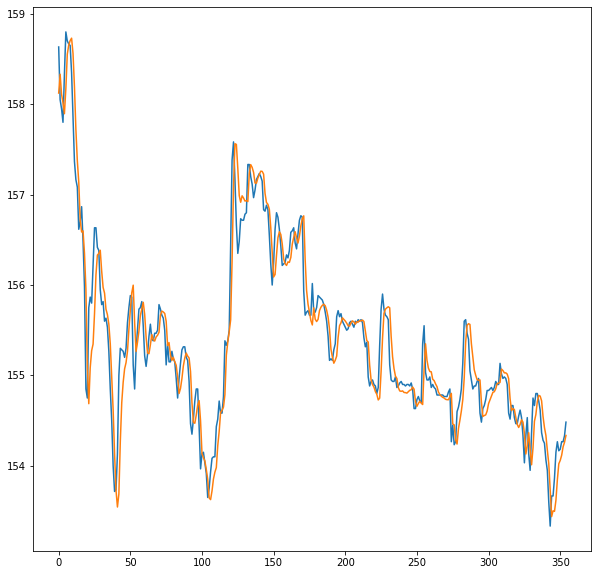

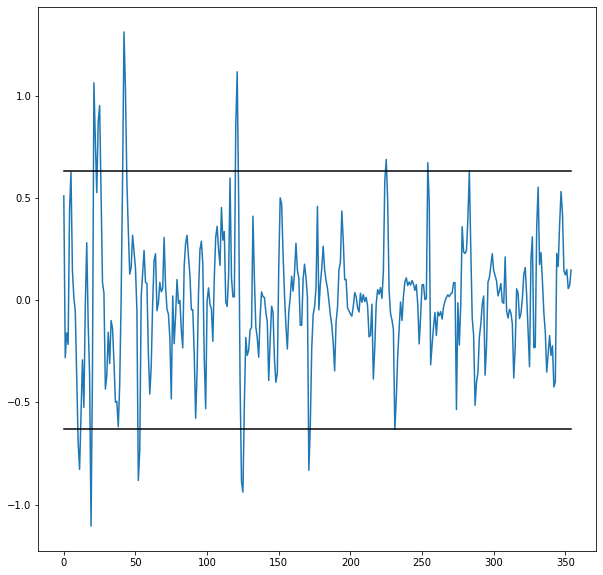

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 10))
ax1 = plt.subplot()
plt.plot(range(len(price_list)), price_list)
plt.plot(range(len(pred_list)), pred_list)

figure(figsize=(10, 10))
ax2 = plt.subplot()
plt.plot(range(len(price_list)),mean_rev)
plt.plot(range(len(price_list)), [std_up] *  len(price_list), color = 'black')
plt.plot(range(len(price_list)), [std_down] *  len(price_list), color = 'black')

plt.show()